# Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import scipy
import rasterio as rio

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()
import os, sys, itertools, gc, functools
from pathlib import Path

In [3]:
import json
import joblib
import PIL
import PIL.ImageDraw
from einops import rearrange

In [4]:
import torch
from transformers import AutoImageProcessor, AutoModel
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Setup Constants

In [5]:
band_filenames = [
    'result.tif',
    'result_Red.tif',
    'result_Green.tif',
    'result_Blue.tif',
    'result_NIR.tif',
    'result_RedEdge.tif',
]


bands_dict = {
    'wr': 'Wideband Red',
    'wg': 'Wideband Green',
    'wb': 'Wideband Blue',
    'r': 'Narrowband Red',
    'g': 'Narrowband Green',
    'b': 'Narrowband Blue',
    'nir': 'Near Infrared',
    're': 'Red Edge',
}

band_keys = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 're']

# Prepare Datasets

In [6]:
casuarina_93 = Path('Data/casuarina-20220418-93deg')
casuarina_183 = Path('Data/casuarina_20220418_183deg')
chestnut_may = Path('Data/chestnut_nature_park_20210510_90deg43m85pct255deg')
chestnut_dec = Path('Data/chestnut_nature_park_20201218')

In [7]:
def load_dataset(ds_path):
    filenames = [ds_path / i for i in band_filenames]
    arrs = [rio.open(i).read() for i in filenames]
    arrs[0] = arrs[0][:3]
    arrs = np.concatenate(arrs)
    return arrs

In [8]:
casuarina_ds = load_dataset(casuarina_93)
casuarina_183ds = load_dataset(casuarina_183)
chestnut_may_ds = load_dataset(chestnut_may)
chestnut_dec_ds = load_dataset(chestnut_dec)

In [9]:
print(casuarina_ds.shape)
print(casuarina_183ds.shape)
print(chestnut_may_ds.shape)
print(chestnut_dec_ds.shape)

(8, 8482, 7762)
(8, 8494, 8410)
(8, 8088, 5392)
(8, 7620, 4876)


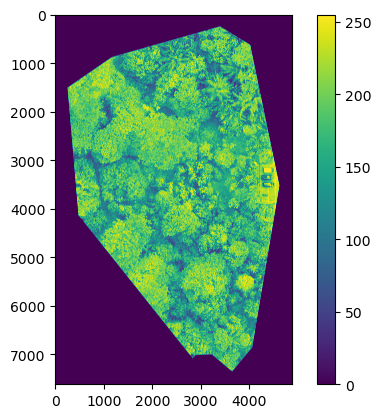

In [10]:
plt.imshow(chestnut_dec_ds[0])
plt.colorbar()
plt.show()

In [11]:
casuarina_93_bounds = pd.read_csv(casuarina_93/'bounds.csv')
casuarina_183_bounds = pd.read_csv(casuarina_183/'bounds.csv')
chestnut_may_bounds = pd.read_csv(chestnut_may/'bounds.csv')
chestnut_dec_bounds = pd.read_csv(chestnut_dec/'bounds.csv')

In [12]:
casuarina_93_bounds['ds'] = 'casuarina'
casuarina_93_bounds['capture'] = '93deg'
casuarina_183_bounds['ds'] = 'casuarina'
casuarina_183_bounds['capture'] = '183deg'
chestnut_may_bounds['ds'] = 'chestnut'
chestnut_may_bounds['capture'] = 'may'
chestnut_dec_bounds['ds'] = 'chestnut'
chestnut_dec_bounds['capture'] = 'dec'

In [13]:
casuarina_new_bounds = pd.read_csv('new_bounds.csv')
casuarina_new_bounds = casuarina_new_bounds[casuarina_new_bounds['img'].apply(lambda x: 'casuarina' in x)]
casuarina_93deg_new_bounds = casuarina_new_bounds[casuarina_new_bounds['img'].apply(lambda x: '93' in x)]
[len(json.loads(casuarina_93deg_new_bounds.iloc[i]['label'])) for i in range(len(casuarina_93deg_new_bounds))]
casuarina_93deg_new_bounds = pd.concat([pd.DataFrame(json.loads(casuarina_93deg_new_bounds.iloc[i]['label'])) for i in [0]])


In [14]:
for df in [casuarina_93deg_new_bounds]:
    df['name'] = df['polygonlabels'].apply(lambda x: x[0])
    df['x0'] = df['points'].apply(lambda i: min([x for x, y in i])) / 100 * df.iloc[0]['original_width']
    df['x1'] = df['points'].apply(lambda i: max([x for x, y in i])) / 100 * df.iloc[0]['original_width']
    df['y0'] = df['points'].apply(lambda i: min([y for x, y in i])) / 100 * df.iloc[0]['original_height']
    df['y1'] = df['points'].apply(lambda i: max([y for x, y in i])) / 100 * df.iloc[0]['original_height']
    df[['x0', 'x1', 'y0', 'y1']] = df[['x0', 'x1', 'y0', 'y1']].astype('int32')
casuarina_93deg_new_bounds['ds'] = 'casuarina'
casuarina_93deg_new_bounds['capture'] = '93deg'

In [15]:
casuarina_93_bounds = casuarina_93deg_new_bounds[casuarina_93_bounds.columns].copy()
len(casuarina_93_bounds), len(chestnut_may_bounds), len(chestnut_dec_bounds)

(118, 34, 33)

In [16]:
def produce_crop(ds, y0, y1, x0, x1):
    return ds[:,y0:y1,x0:x1]

In [17]:
casuarina_93_bounds['crop'] = casuarina_93_bounds[['y0', 'y1', 'x0', 'x1']].apply(lambda x: produce_crop(casuarina_ds, *x), axis=1)
#casuarina_183_bounds['crop'] = casuarina_183_bounds[['y0', 'y1', 'x0', 'x1']].apply(lambda x: produce_crop(casuarina_183ds, *x), axis=1)
chestnut_may_bounds['crop'] = chestnut_may_bounds[['y0', 'y1', 'x0', 'x1']].apply(lambda x: produce_crop(chestnut_may_ds, *x), axis=1)
chestnut_dec_bounds['crop'] = chestnut_dec_bounds[['y0', 'y1', 'x0', 'x1']].apply(lambda x: produce_crop(chestnut_dec_ds, *x), axis=1)

In [18]:
def sample_crops(dataset, bounds):
    test_ds = []
    
    for _, row in bounds.iterrows(): 
        label = row['name']  # Assign label
        
        # Extract bounding box coordinates
        x0, x1 = row['x0'], row['x1']
        y0, y1 = row['y0'], row['y1']
        
        # Extract the crop region from dataset
        crop = dataset[:, y0:y1, x0:x1]  
        
        # Check if the crop contains only blank pixels (all zero)
        blank_mask = np.all(crop == 0, axis=0)  # Check per pixel (y, x)
        if np.all(blank_mask):  # Skip completely blank crops
            continue
        
        test_ds.append((crop, label)) 

    return test_ds  

In [19]:
casuarina_test = sample_crops(casuarina_ds, casuarina_93_bounds)
print(len(casuarina_test))
casuarina_183test = sample_crops(casuarina_183ds, casuarina_183_bounds)
print(len(casuarina_183test))
chestnut_may_test = sample_crops(chestnut_may_ds, chestnut_may_bounds)
print(len(chestnut_may_test))
chestnut_dec_test = sample_crops(chestnut_dec_ds, chestnut_dec_bounds)
print(len(chestnut_dec_test))

118
8
34
33


In [20]:
casuarina_93_bounds['name'].unique()

array(['Macaranga Gigantea', 'Palm Tree', 'Campnosperma Auriculatum',
       '_Unknown', 'Prunus polystachya', 'Ixonanthes reticulata',
       'Fagraea fragans', 'Koompassia malaccensis', 'Litsea firma',
       'Shorea Leprosula', 'Alstonia Angulstiloba', 'Syzygium grande'],
      dtype=object)

In [21]:
#bounds_df = pd.concat((casuarina_93_bounds, casuarina_183_bounds, chestnut_may_bounds, chestnut_dec_bounds))

In [22]:
chestnut_dec_bounds['name'].unique()

array(['Falcataria Moluccana', 'Ficus Variegata', 'Bridelia Sp.',
       'Spathodea Campanulatum', 'Terminalia Catappa', 'Shorea Leprosula',
       'Syzygium Polyanthum', 'Cinnamomum Iners', 'Clausena Excavata',
       'Alstonia Angulstiloba', 'Sandoricum Koetjape',
       'Sterculia Parviflora', 'Claoxylon Indicum', 'Pometia Pinnata',
       'Calophyllum', 'Pennisetum Purpureum', 'Campnosperma Auriculatum',
       'Leea Indica', 'Dillenia Suffruticosa'], dtype=object)

In [23]:
chestnut_may_bounds['name'].unique()

array(['Falcataria Moluccana', 'Ficus Variegata', 'Bridelia Sp.',
       'Spathodea Campanulatum', 'Terminalia Catappa', 'Shorea Leprosula',
       'Syzygium Polyanthum', 'Cinnamomum Iners', 'Clausena Excavata',
       'Cratoxylum Formosum', 'Alstonia Angulstiloba',
       'Sandoricum Koetjape', 'Sterculia Parviflora', 'Claoxylon Indicum',
       'Pometia Pinnata', 'Calophyllum', 'Pennisetum Purpureum',
       'Campnosperma Auriculatum', 'Leea Indica', 'Dillenia Suffruticosa'],
      dtype=object)

In [24]:
def plot_bands(dataset, n):
    crop, label = dataset[n]  

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  
    fig.suptitle(f"8 Band Images of the Crop -  {label}", fontsize=16)  # Show label

    for i in range(8): 
        ax = axes[i // 4, i % 4]  
        ax.imshow(crop[i, :, :], cmap="viridis")  
        ax.set_title(f"Band: {band_keys[i]}")  
        ax.axis("on") 

    plt.tight_layout()
    plt.show()
    
def plot_stacked_bands(dataset, n):
    crop, label = dataset[n]  

    band_indices = [0, 1, 7]
    stacked_image = np.stack([crop[i, :, :] for i in band_indices], axis=-1)

    # Normalize each channel to [0, 1] for visualization
    stacked_image = (stacked_image - stacked_image.min(axis=(0, 1))) / (stacked_image.max(axis=(0, 1)) - stacked_image.min(axis=(0, 1)) + 1e-6)

    plt.figure(figsize=(6, 6))
    plt.imshow(stacked_image)
    plt.title(f"Stacked Pseudo-RGB Image (Bands 0, 1, 7) - {label}")
    plt.axis("off")
    plt.show()

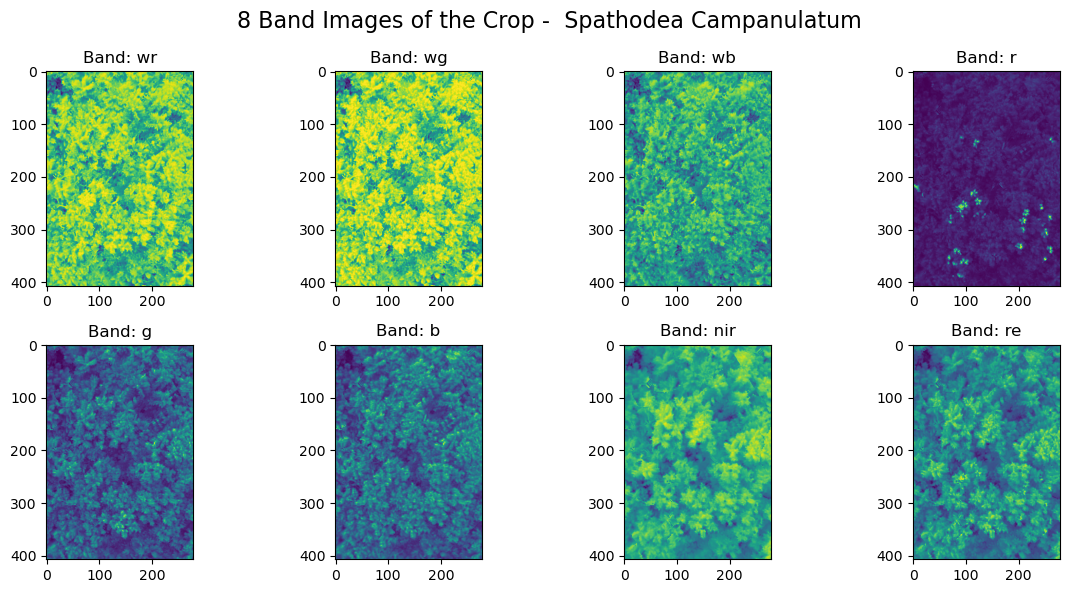

In [25]:
plot_bands(chestnut_dec_test, 32)

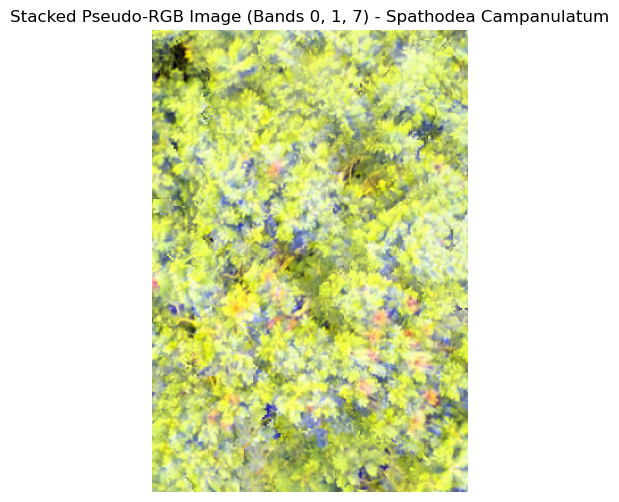

In [26]:
plot_stacked_bands(chestnut_dec_test, 32)

### Remove NAN and classes that does not exist in both may and dec

In [27]:
def check_nan_inf_in_dataset(dataset):
    for i, (image, label) in enumerate(dataset):
        if np.any(np.isnan(image)):
            print(f"NaN found in sample {i}, image")
        if np.any(np.isinf(image)):
            print(f"inf found in sample {i}, image")
    print("Check complete.")

check_nan_inf_in_dataset(chestnut_dec_test)

# Initialize a new list to store valid (image, label) pairs
chestnut_dec_test_new = []

for image, label in chestnut_dec_test:
    if not np.any(np.isnan(image)) and not np.any(np.isinf(image)):
        chestnut_dec_test_new.append((image, label))

# Verify
print(f"Original length: {len(chestnut_dec_test)}")
print(f"New length (NaN removed): {len(chestnut_dec_test_new)}")


#Remove'Cratoxylum Formosum' and 'Campnosperma Auriculatum' from chestnut_may_test
chestnut_may_test_new = []

for image, label in chestnut_may_test:
    if not (label == 'Cratoxylum Formosum' or
         label == 'Campnosperma Auriculatum'):
        chestnut_may_test_new.append((image, label))

print()
print("chestnut_may")
print(f"Original length: {len(chestnut_may_test)}")
print(f"New length (NaN removed): {len(chestnut_may_test_new)}")


NaN found in sample 4, image
NaN found in sample 12, image
NaN found in sample 27, image
Check complete.
Original length: 33
New length (NaN removed): 30

chestnut_may
Original length: 34
New length (NaN removed): 32


In [28]:
may_classes = set(label for _, label in chestnut_may_test_new)
casuarina_classes = set(label for _, label in casuarina_test)

ood_classes = casuarina_classes - may_classes
print("Classes in casuarina but not in chestnut:", sorted(ood_classes))

print("Chestnut: ",sorted(may_classes))
print("Casuarina: " ,sorted(casuarina_classes))

Classes in casuarina but not in chestnut: ['Campnosperma Auriculatum', 'Fagraea fragans', 'Ixonanthes reticulata', 'Koompassia malaccensis', 'Litsea firma', 'Macaranga Gigantea', 'Palm Tree', 'Prunus polystachya', 'Syzygium grande', '_Unknown']
Chestnut:  ['Alstonia Angulstiloba', 'Bridelia Sp.', 'Calophyllum', 'Cinnamomum Iners', 'Claoxylon Indicum', 'Clausena Excavata', 'Dillenia Suffruticosa', 'Falcataria Moluccana', 'Ficus Variegata', 'Leea Indica', 'Pennisetum Purpureum', 'Pometia Pinnata', 'Sandoricum Koetjape', 'Shorea Leprosula', 'Spathodea Campanulatum', 'Sterculia Parviflora', 'Syzygium Polyanthum', 'Terminalia Catappa']
Casuarina:  ['Alstonia Angulstiloba', 'Campnosperma Auriculatum', 'Fagraea fragans', 'Ixonanthes reticulata', 'Koompassia malaccensis', 'Litsea firma', 'Macaranga Gigantea', 'Palm Tree', 'Prunus polystachya', 'Shorea Leprosula', 'Syzygium grande', '_Unknown']


## LDA Linear Discriminant Analysis

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


  0%|          | 0/32 [00:00<?, ?it/s]

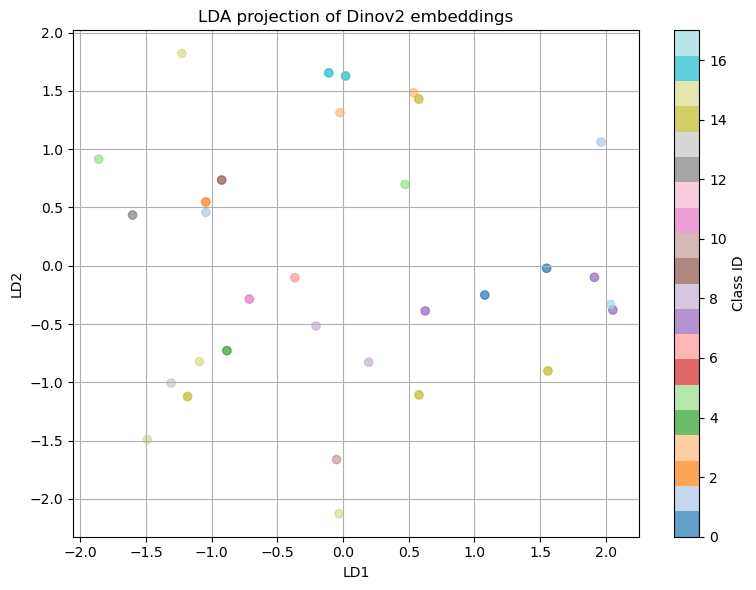

In [29]:
# Load pretrained model and processor
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.eval()

# Normalize individual channel to [0, 255]
def normalize_image(img_slice):
    img_min = img_slice.min()
    img_max = img_slice.max()
    if img_max > img_min:
        return ((img_slice - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    else:
        return np.zeros_like(img_slice, dtype=np.uint8)

# Feature extraction
embeddings = []
labels = []

for img, label in tqdm(chestnut_may_test_new):
    img_rgb = np.stack([
        normalize_image(img[0]),
        normalize_image(img[1]),
        normalize_image(img[7])
    ], axis=2)  

    inputs = processor(images=img_rgb, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use mean pooling over spatial tokens
    feature = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings.append(feature)
    labels.append(label)

embeddings = np.array(embeddings)
labels = np.array(labels)

# Encode labels to integer
le = LabelEncoder()
label_ids = le.fit_transform(labels)

# Fit
lda = LinearDiscriminantAnalysis()
lda_features = lda.fit_transform(embeddings, label_ids)

# Save LDA model
joblib.dump(lda, "lda_model.pkl")
np.save("lda_embeddings.npy", lda_features)
np.save("lda_labels.npy", label_ids)


plt.figure(figsize=(8, 6))
if lda_features.shape[1] == 1:
    plt.scatter(lda_features[:, 0], np.zeros_like(lda_features[:, 0]), c=label_ids, cmap='tab20', alpha=0.7)
elif lda_features.shape[1] >= 2:
    plt.scatter(lda_features[:, 0], lda_features[:, 1], c=label_ids, cmap='tab20', alpha=0.7)
plt.colorbar(label="Class ID")
plt.title("LDA projection of Dinov2 embeddings")
plt.xlabel("LD1")
plt.ylabel("LD2" if lda_features.shape[1] >= 2 else "")
plt.grid(True)
plt.tight_layout()
plt.savefig("lda_visualization.png")
plt.show()


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clustering Accuracy: 46.88%


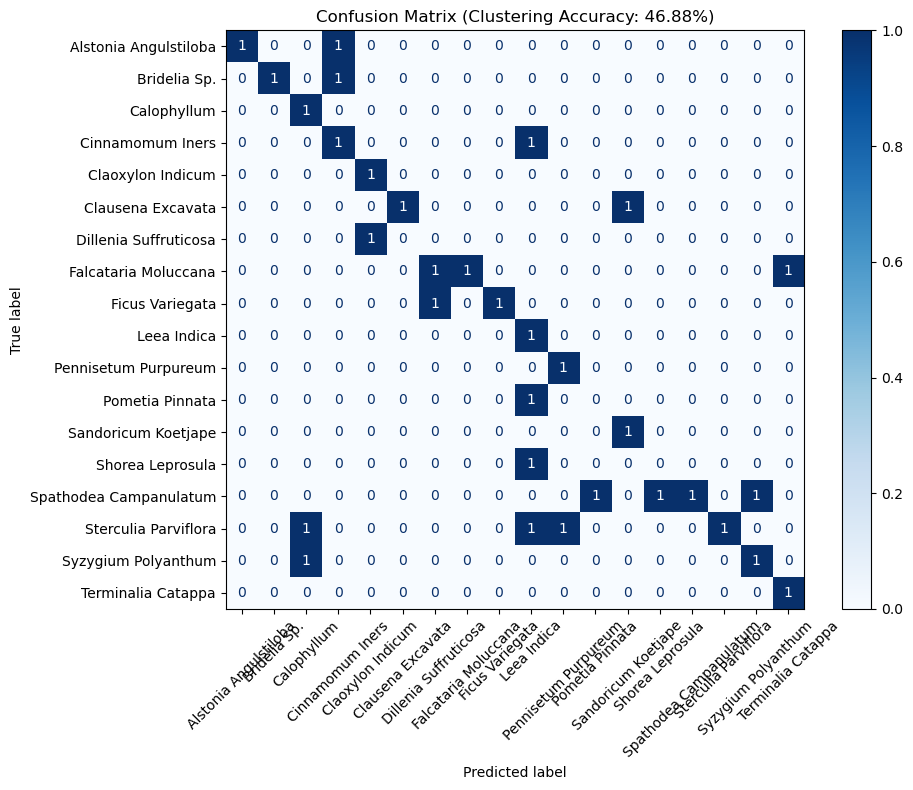

In [30]:
le = LabelEncoder()
label_ids = le.fit_transform(labels)
n_classes = len(np.unique(label_ids))

kmeans = KMeans(n_clusters=n_classes, random_state=42)
pred_labels = kmeans.fit_predict(lda_features)

def best_map(true_labels, pred_labels):
    D = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-D)
    new_preds = np.zeros_like(pred_labels)
    for i, j in zip(col_ind, row_ind):
        new_preds[pred_labels == i] = j
    return new_preds

matched_preds = best_map(label_ids, pred_labels)
acc = accuracy_score(label_ids, matched_preds)
print(f"Clustering Accuracy: {acc * 100:.2f}%")

cm = confusion_matrix(label_ids, matched_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix (Clustering Accuracy: {acc * 100:.2f}%)")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

In [31]:
from sklearn.cluster import KMeans

lda = joblib.load("lda_model.pkl")

lda_scores_train = lda.transform(embeddings)  # [N_train, num_topics]
kmeans_model = KMeans(n_clusters=18, random_state=42).fit(lda_scores_train)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Prepare Embeddings for Chestnut Dec and Casuarina

In [32]:
def prepare_embeddings_and_calculate_energy(dataset):
    embeddings = []
    labels = []

    for img, label in tqdm(dataset):
        img_rgb = np.stack([
            normalize_image(img[0]),
            normalize_image(img[1]),
            normalize_image(img[7])
        ], axis=2)  # (H, W, 3), dtype: uint8

        inputs = processor(images=img_rgb, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        # Use mean pooling over spatial tokens
        feature = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(feature)
        labels.append(label)

    # Convert to arrays
    embeddings = np.array(embeddings)
    
    new_feature = lda.transform(embeddings) 

    lda_scores = lda.transform(embeddings) 
    cluster_distances = kmeans_model.transform(lda_scores)  
    energy = np.log(np.sum(np.exp(-cluster_distances)) / np.sum(np.exp(-cluster_distances), axis=1))

    # Prepare labels (convert to numeric for grouping)
    le = LabelEncoder()
    label_ids = le.fit_transform(labels)
    unique_classes = le.classes_

    # Plot energy distribution
    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("hsv", len(unique_classes))

    for i, class_label in enumerate(unique_classes):
        class_energy = energy[label_ids == i]
        sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)

    plt.title("Energy Distribution per Class")
    plt.xlabel("Energy (L2 Norm)")
    plt.ylabel("Density")
    plt.legend(title="Class")
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig("energy_distribution_183.png", dpi=300)
    plt.show()
    
    return energy, labels

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.k

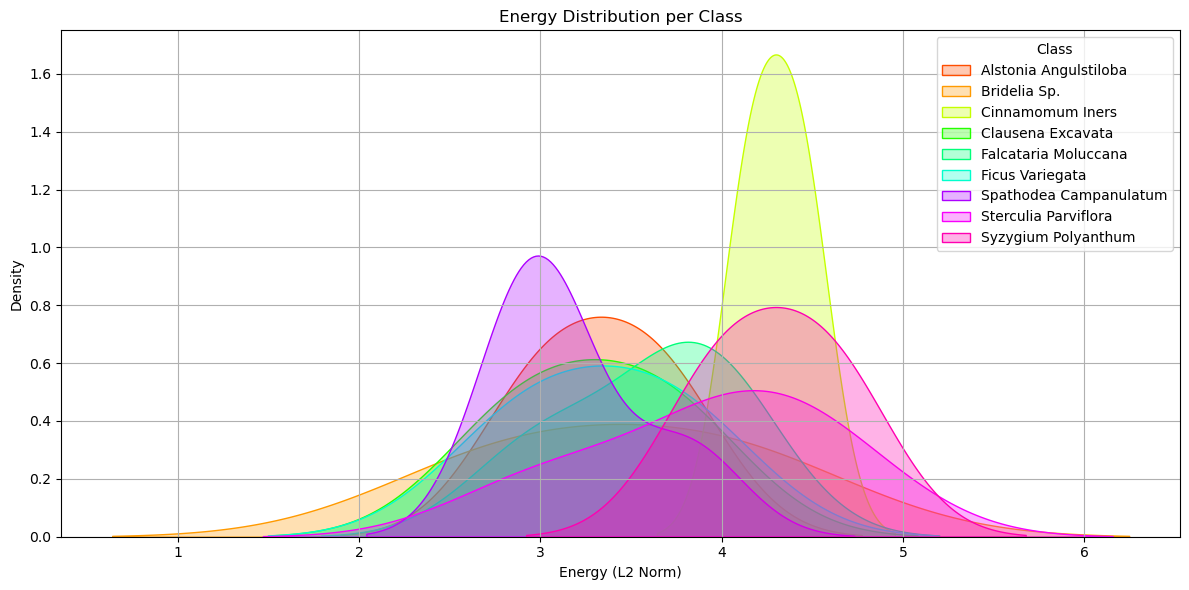

In [33]:
energy_may, labels_may = prepare_embeddings_and_calculate_energy(chestnut_may_test_new)

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.k

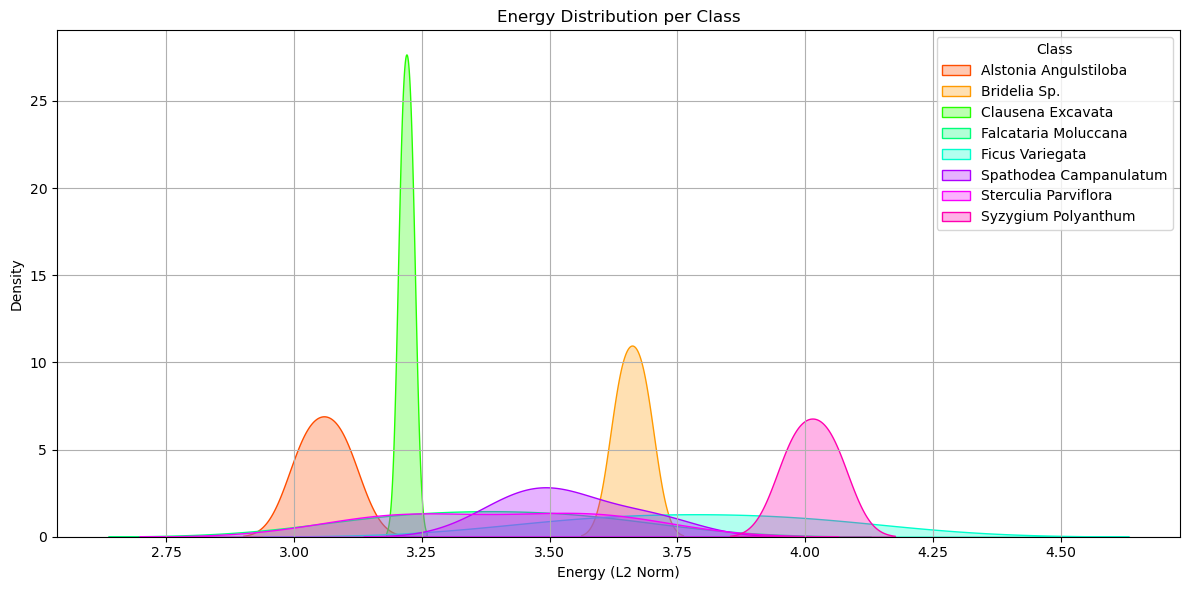

In [34]:
energy_dec, labels_dec = prepare_embeddings_and_calculate_energy(chestnut_dec_test_new)

  0%|          | 0/118 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20936\2967964057.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(class_energy, label=class_label, color=palette[i], fill=True, alpha=0.3)


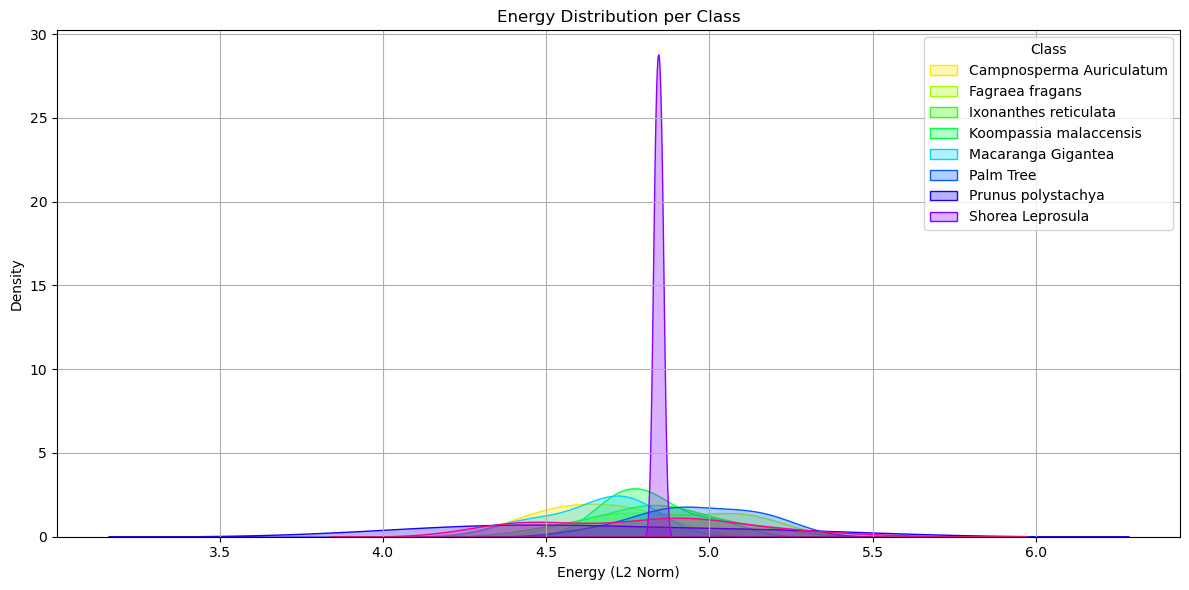

In [35]:
energy_93, labels_93 = prepare_embeddings_and_calculate_energy(casuarina_test)

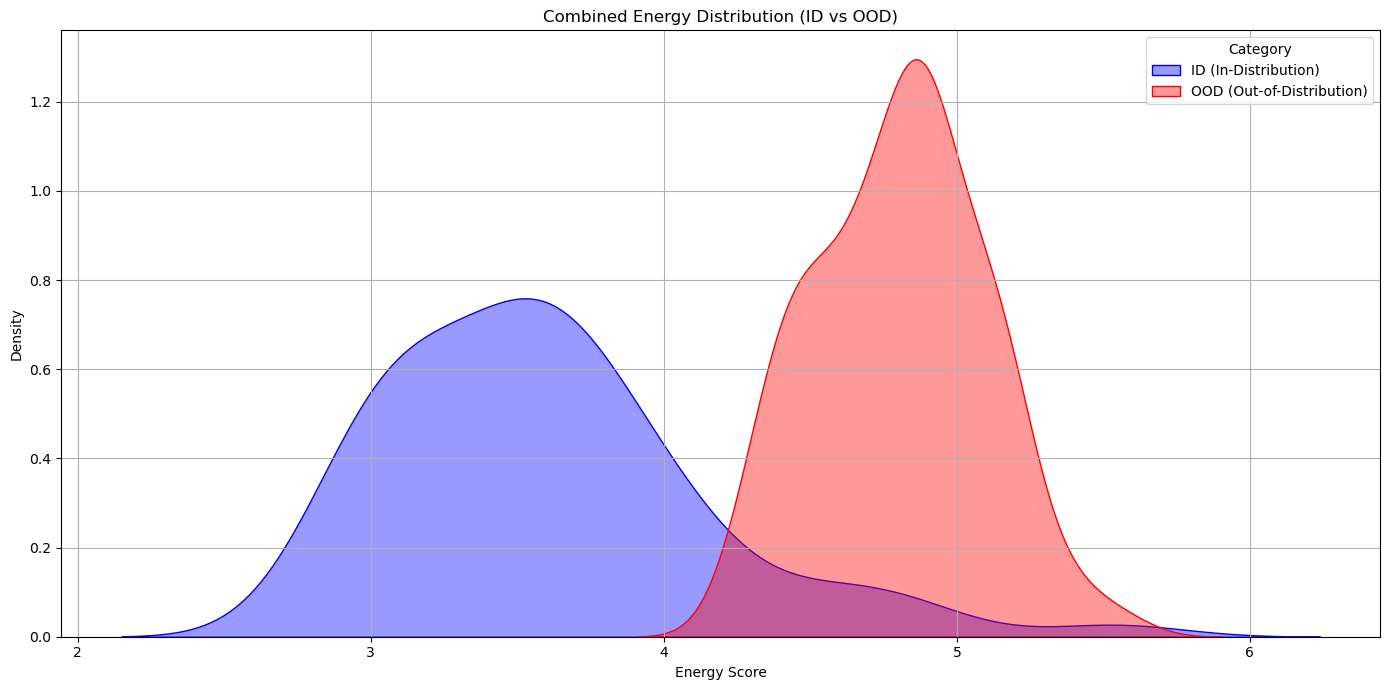

In [36]:
# Based on OOD classes obtained above
ood_classes = {
    'Campnosperma Auriculatum', 'Fagraea fragans', 'Ixonanthes reticulata',
    'Koompassia malaccensis', 'Litsea firma', 'Macaranga Gigantea',
    'Palm Tree', 'Prunus polystachya', 'Syzygium grande', '_Unknown'
}

# Combine energy and labels
all_energy = np.concatenate([energy_dec, energy_93,energy_may])
all_labels = np.concatenate([labels_dec, labels_93,labels_may])

# Create binary ID/OOD labels (1=OOD, 0=ID)
is_ood = np.array([label in ood_classes for label in all_labels])

# Plot setup
plt.figure(figsize=(14, 7))
palette = {'ID': 'blue', 'OOD': 'red'}

# Plot KDE for ID vs OOD
sns.kdeplot(
    data=all_energy[~is_ood],
    label='ID (In-Distribution)',
    color=palette['ID'],
    fill=True,
    alpha=0.4
)
sns.kdeplot(
    data=all_energy[is_ood],
    label='OOD (Out-of-Distribution)',
    color=palette['OOD'],
    fill=True,
    alpha=0.4
)

plt.title("Combined Energy Distribution (ID vs OOD)")
plt.xlabel("Energy Score")
plt.ylabel("Density")
plt.legend(title="Category")
plt.grid(True)
plt.tight_layout()
plt.show()


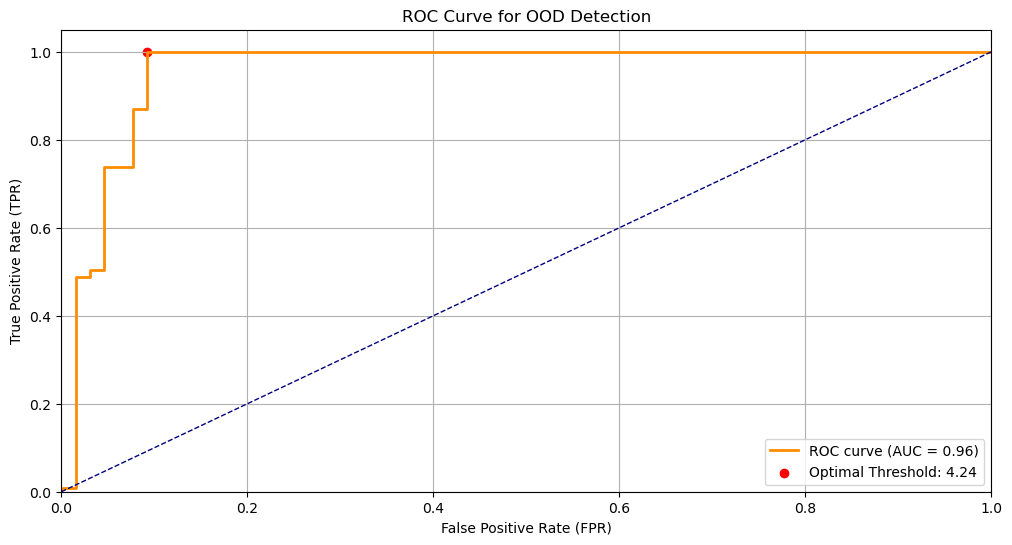

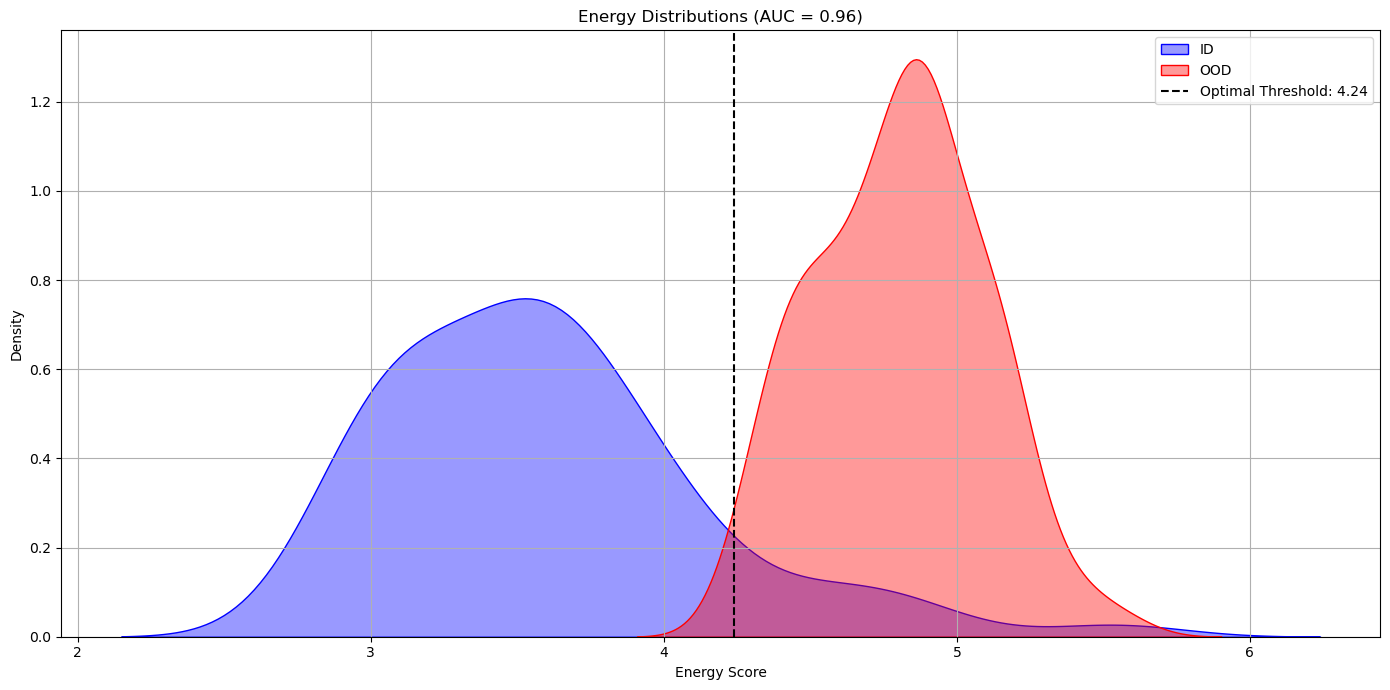

              precision    recall  f1-score   support

          ID       1.00      0.91      0.95        65
         OOD       0.95      1.00      0.97       115

    accuracy                           0.97       180
   macro avg       0.98      0.95      0.96       180
weighted avg       0.97      0.97      0.97       180

Optimal Threshold: 4.2403
AUC: 0.9592


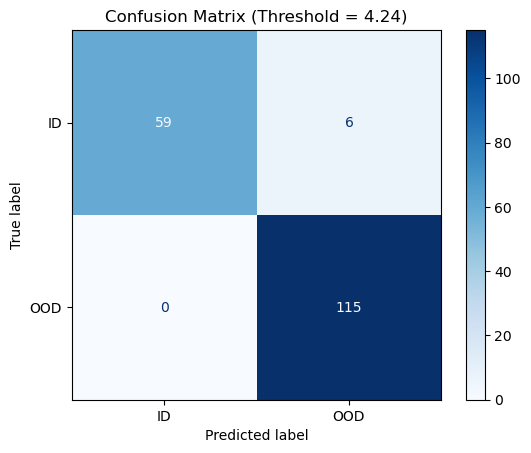

In [37]:
fpr, tpr, thresholds = roc_curve(is_ood, all_energy)
roc_auc = auc(fpr, tpr)

# Find optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red',
            label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OOD Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("ROC_Chestnut.png", dpi=300)
plt.show()

# Plot KDE distributions
plt.figure(figsize=(14, 7))
sns.kdeplot(all_energy[~is_ood], label='ID', color='blue', fill=True, alpha=0.4)
sns.kdeplot(all_energy[is_ood], label='OOD', color='red', fill=True, alpha=0.4)
plt.axvline(optimal_threshold, color='black', linestyle='--', 
            label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.title(f"Energy Distributions (AUC = {roc_auc:.2f})")
plt.xlabel("Energy Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Energy_Distribution_Chestnut.png", dpi=300)
plt.show()

pred_ood = (all_energy >= optimal_threshold).astype(int)  # Higher energy = more likely OOD

# Print classification report
print(classification_report(is_ood, pred_ood, target_names=['ID', 'OOD']))
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Plot confusion matrix
cm = confusion_matrix(is_ood, pred_ood)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ID', 'OOD'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold = {optimal_threshold:.2f})")
plt.grid(False)
plt.savefig("Classification_confusion_matrix_chestnut.png", dpi=300)
plt.show()

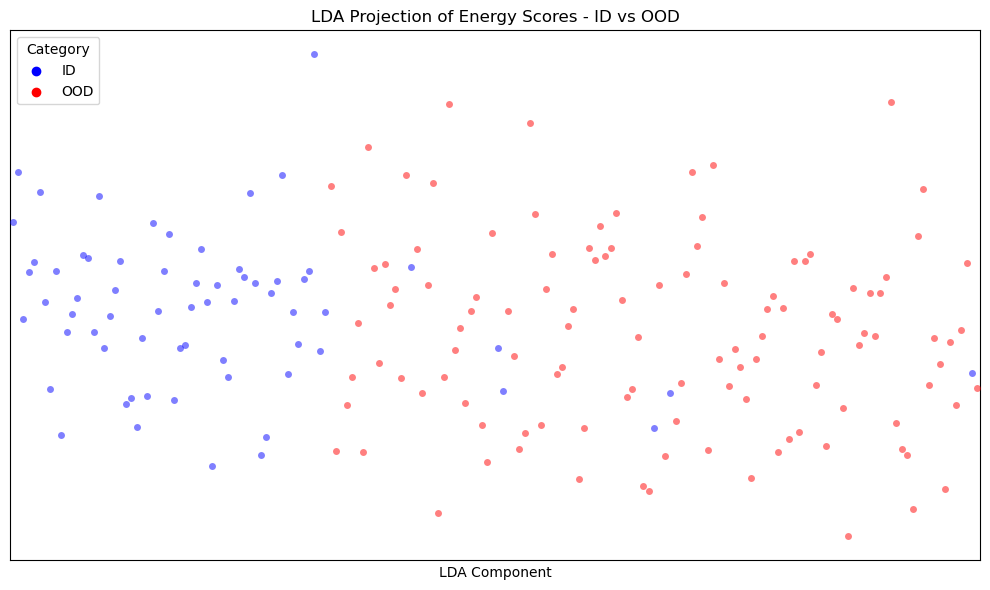

In [38]:
if len(all_energy.shape) == 1:
    all_energy = all_energy.reshape(-1, 1)

lda = LinearDiscriminantAnalysis(n_components=1)
lda_proj = lda.fit_transform(all_energy, is_ood)

plt.figure(figsize=(10, 6))
sns.stripplot(
    x=lda_proj.flatten(),
    y=np.random.normal(0, 0.05, size=len(lda_proj)), 
    hue=['OOD' if ood else 'ID' for ood in is_ood],
    palette=palette,
    alpha=0.5,
    jitter=0.1
)

plt.title("LDA Projection of Energy Scores - ID vs OOD")
plt.xlabel("LDA Component")
plt.xticks([]) 
plt.yticks([])  
plt.legend(title="Category")
plt.grid(True)
plt.tight_layout()
plt.show()